## Load in data

In [1]:
%load_ext autoreload
%autoreload 2
from ais_dataloader import *
import ipywidgets as widgets
from IPython.display import display


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-01', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)


Combining AIS CSVs into a single df: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


Processing AIS data...
Removed 5167987 out of 7296275 rows due to invalid COG, SOG, LAT, or Heading values.


## Fit GP Models

In [11]:
import torch
import gpytorch
from multioutput_gp import MultiOutputExactGPModel


num_trajectories = 10
models = []
likelihoods = []
losses = []

for idx in range(num_trajectories):
    mmsi, times, state_trajectory = gp_regression_dataset[idx]
    X = torch.tensor(times, dtype=torch.float32).unsqueeze(1).to(device)
    Y = torch.tensor(state_trajectory, dtype=torch.float32).to(device)
    num_outputs = Y.shape[1]

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs).to(device)
    model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    num_epochs = 100  # Adjust as needed

    for i in range(num_epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, Y)
        loss.backward()
        optimizer.step()
    print(f"Trajectory {idx}: Final Loss {loss.item():.4f}")

    models.append(model)
    likelihoods.append(likelihood)
    losses.append(loss.item())

/tmp/ipykernel_6650/662776664.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(times, dtype=torch.float32).unsqueeze(1).to(device)
/tmp/ipykernel_6650/662776664.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(state_trajectory, dtype=torch.float32).to(device)


Trajectory 0: Final Loss 1462564683776.0000
Trajectory 1: Final Loss 2816160038912.0000
Trajectory 2: Final Loss 1527554244608.0000
Trajectory 3: Final Loss 2762086285312.0000
Trajectory 4: Final Loss 1729112571904.0000
Trajectory 5: Final Loss 1760475611136.0000
Trajectory 6: Final Loss 539256782848.0000
Trajectory 7: Final Loss 2508035981312.0000
Trajectory 8: Final Loss 1181794304000.0000
Trajectory 9: Final Loss 1044069744640.0000


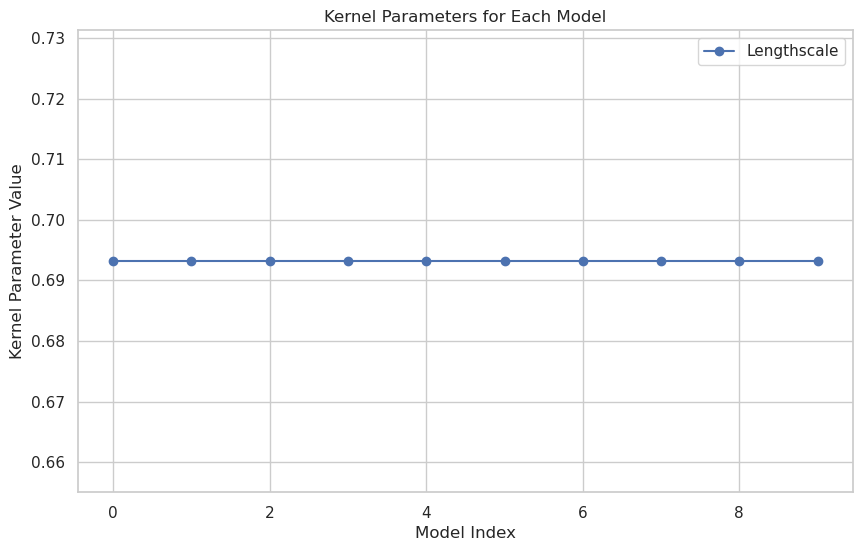

In [12]:
import matplotlib.pyplot as plt

# Extract kernel parameters (e.g., lengthscale) for each model
lengthscales = [
    model.covar_module.data_covar_module.lengthscale.item() for model in models
]

# Plot the kernel parameters
plt.figure(figsize=(10, 6))
plt.plot(range(len(models)), lengthscales, marker='o', label='Lengthscale')
plt.xlabel('Model Index')
plt.ylabel('Kernel Parameter Value')
plt.title('Kernel Parameters for Each Model')
plt.legend()
plt.grid(True)
plt.show()

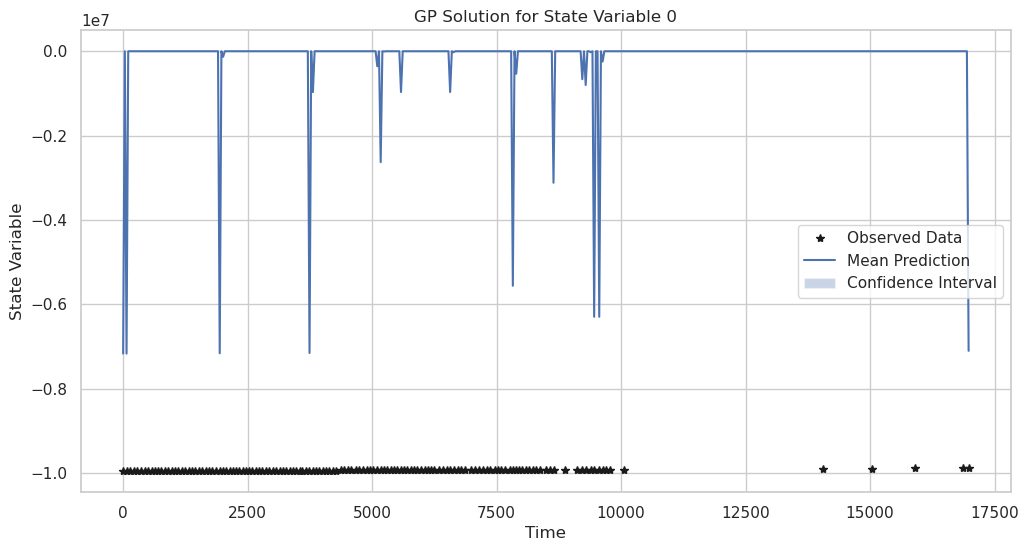

In [14]:
# Set the model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Generate test inputs (e.g., evenly spaced time points)
test_times = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_times))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(times.cpu(), state_trajectory[:, 0].cpu(), 'k*', label='Observed Data')
plt.plot(test_times.cpu(), mean[:, 0].cpu(), 'b', label='Mean Prediction')
plt.fill_between(
    test_times.cpu().squeeze(),
    lower[:, 0].cpu(),
    upper[:, 0].cpu(),
    alpha=0.3,
    label='Confidence Interval'
)
plt.xlabel('Time')
plt.ylabel('State Variable')
plt.title('GP Solution for State Variable 0')
plt.legend()
plt.grid(True)
plt.show()

### Plot GP Solution

In [ ]:
# train_x ~ times
# train_y ~ state_trajectory

# test_X ~ times

## Plotting


In [ ]:
mmsi, times, state_trajectory = gp_regression_dataset[1]

display(times.shape, state_trajectory.shape)
from plotting_utils import *

plot_single_ship_state_trajectory(0, times, state_trajectory)
plot_single_ship_path(0, times, state_trajectory)

IndexError: list index out of range